# Modelo de Ising: Metropolis

En este notebook se describe el modelo de Ising por medio métodos Monte Carlo: Metropolis. Se busca dar descripción cuantitativa de un ferromagneto por medio de la simulación estocástica Metropolis. Con Metropolis-Montecarlo se busca evolucionar el sistema a un estado de equilibrio dada una temperatura $T$; mientras que con integración Montecarlo se pretende determinar varias cantidades observables del sistema tales como la magnetización y la energía (?).

## 1. Introducción...

## 2. Simulación

In [1]:
using PyPlot

using PyCall
np = pyimport("numpy")
include("Modelo de Ising 2D.jl") #Contiene la función que me genera mi mallado circular

simulacionMontecarlo

### 2.1 Armado de la red y cálculo de la energía del sistema.

Se va a construir una red de $N\times N$ con $N^2$ número de átomos de la red. El primer paso para la simulación es generar una lista con los cuatro vecinos de cada sitio implementando condiciones de frontera periódicas. Quiere decir que cada sitio de la red $(i,j)$ va a tener cuatro vecinos (arriba, abajo, derecha e izquierda). 

Posteriormente, calculamos la energía de un par de configuraciones de spines y un valor de $J=0.5$ (Que se ha tomado como consenso en la clase). La energía individual está dada por

$$
E=-J\sum_{\langle ij\rangle}s_is_j
$$

con $s_i,s_j=\pm1$ dependiendo si la proyección de espín apunta hacia arriba o hacia abajo del eje de cuantización.

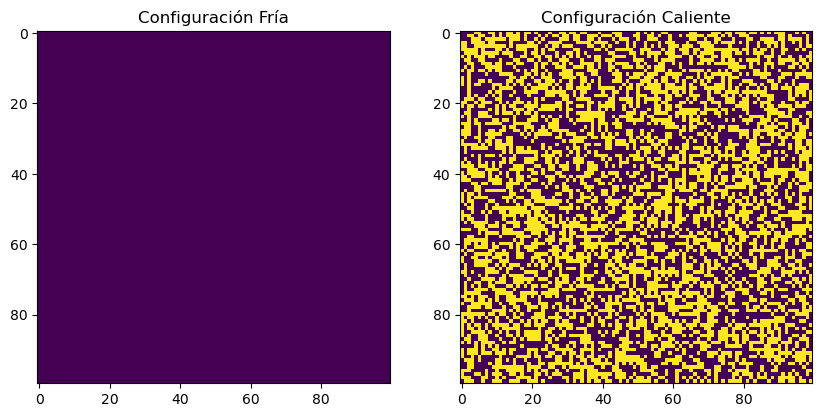

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/rogve98/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject Text(0.5, 1.0, 'Configuración Caliente')

In [2]:
"""
Parámetros:
N := tamaño de un lado de la malla de N×N
f := f∈(0,1); flotante para establecer el porcentaje de spines hacia abajo (amarillos)
"""
N = 100
f = 0.5
redCaliente = redSpinesCaliente(N,f)
redFria = redSpinesFrio(100)

figure(figsize=(10,6))

subplot(1,2,1)
imshow(redFria)
title("Configuración Fría")

subplot(1,2,2)
imshow(redCaliente)
title("Configuración Caliente")


Queremos que nuestra red de espines la podamos expresar en un un arreglo 1-dimensional con la siguiente lógica

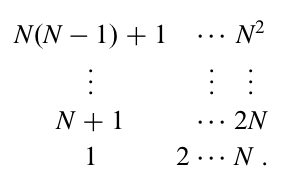

Para ello generamos una función que nos devuelva dicho arreglo con las entradas de los valores de la red de spines.

In [3]:
"""
Definimos un objeto que contenga la información de las configuraciones caliente, fría
y el número N del tamaño de la red de spines
"""
mutable struct MicroEstados
    σ::Array{Int,1} #Arreglo de spines aleatorios
    N::Int          #Arreglo de N×N de spines
    frio::Array{Int,1} #Arreglo de spines alineados
end

MicroEstados

**Texto...**

In [4]:
"""
Parámetros:

N := tamaño de la red
"""
N=1000
microEstados = Lista(N,0.5)
microEstados.N

1000

**Texto..**

In [5]:
"""
Parámetros:
microEstados := objeto MicroEstados
i            := sitio
"""
i = 1
vecinos(microEstados,5)

([1, 1, -1, 1], [1, 1, 1, 1])

La energía para dados dos átomos en interacción esta dada por la siguiente expresión desarrollada

$$
\Delta E_{ij}=-2J\sigma_{i,j}(\sigma_{i+1,j}+\sigma_{i-1},j+\sigma_{i,j+1}+\sigma_{i,j-1})-2h\sigma_{i,j}
$$

sin embargo, el último término de la igualadad anterior no lo consideraremos porque no se van a considerar campos externos al sistema de interés (ferromagneto)

In [6]:
"""
Parámetros:

microEstados := objeto MicroEstados
i            := sitio
"""
i = 1
println(energia_i(microEstados,i))
println(energiaTotal(microEstados))

(-4.0, -4.0)
(2504.0, -4.0e6)


### 2.2 Cálculo de la temperatura crítica

Para determinar la temperatura crítica en la que ocurre la transición de fase de ferromagneto a paramagneto, necesitamos determinar la solución de la siguiente ecuación trascendental

$$
2\tanh^2\left(\frac{2J}{K_BT_C}\right)=1
$$

Considerando que $K_B=1$ se encuentra en unidades naturales para que la ecuación tenga sentido. Para ello vamos a determinar la solución mediante el método de Newton-Rhapson.

In [22]:
tCritica(T) = 2tanh(1/T)^2-1

tCritica (generic function with 1 method)

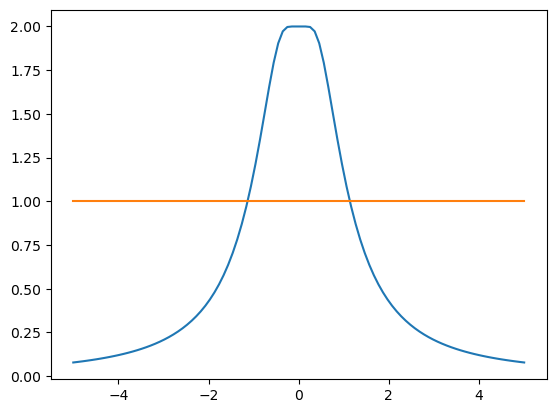

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe08d0108e0>

In [8]:
xs = range(-5, stop = 5, length = 100)
ys = [2*tanh(1/T)^2 for T in xs]
ys1 = [1 for x in xs]
plot(xs,ys)
plot(xs,ys1)

In [25]:
"""
Parámetros:

tempCrítica := función para buscar la raíz, en este caso es
            2tanh²(1/T)-1=0
x_inicial   := donde comienza el algorítmo
ϵ           := paso de integración
n           := número de pasos
"""
x_inicial = 2
ϵ = 0.01
n = 20
raiz = newtonRhapson(tCritica,x_inicial,ϵ,n)

1.134592657106511

### 2.3 Evolución y termalización del sistema

En esta sección se abarcará la integración Montecarlo y la simulación con el algorítmo de Metropolis. La función de partición es la herramienta fundamental por la que se hallan las cantidades observables y la función de estado.

$$
Z = \sum_{C}e^{-\beta E(C)}
$$

donde $\beta=1K_BT$ y la suma corre sobre todas las posibles configuraciones posibles de los átomos de la red, sin embargo realizar cálculos es muy exhaustivo por lo que se requieren otro tipo de técnicas para poder resolver el problema. El algorítmo Metropolis Montecarlo "se centra en el cálculo de probabilidades de transición entre dos diferentes configuraciones (eliminando así la necesidad de la función de partición) y que tiene por objetivo generar  una colección de configuraciones de espines que obedezcan la distribución del ensamble canónico (del Ángel, 2022)"

In [10]:
Metropolis(microEstados,0.5,"fria")

4.0

#### 2.3.2 Simluación Monte-Carlo 

Se utilizará el algorítmo de selección: Metropolis para hacer una iteración de n pasos para poder ver las interacciones que presentan los átomos al voltearle el spín...

In [11]:
"""
Parámetros
microEstados := objeto MicroEstados
T            := temperatura
n            := número de pasos
conf         := configuración caliente o fría, en variable String
"""
T = 1.5
n = 10000
confC = "caliente"
confF = "fria"

enerFria = simulacionMontecarlo(microEstados,T,n,confF)
enerCaliente = simulacionMontecarlo(microEstados,T,n,confC)

10000-element Vector{Float64}:
 2504.0
 2504.0
 2506.0
 2506.0
 2506.0
 2506.0
 2508.0
 2508.0
 2508.0
 2510.0
 2510.0
 2512.0
 2512.0
    ⋮
 3192.0
 3194.0
 3194.0
 3194.0
 3194.0
 3194.0
 3194.0
 3194.0
 3194.0
 3194.0
 3194.0
 3194.0

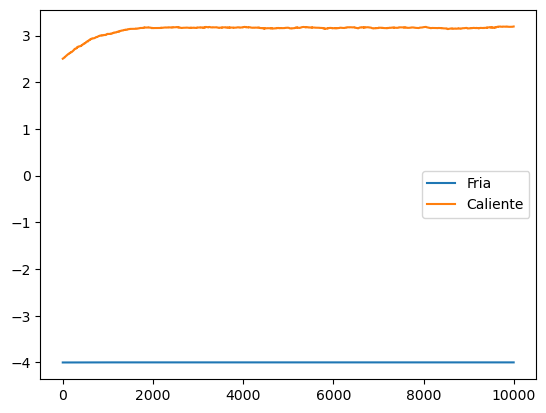

PyObject <matplotlib.legend.Legend object at 0x7fe08cf72f40>

In [12]:
plot(enerFria/1000000,label = "Fria")
plot(enerCaliente/1000, label = "Caliente")
legend()

### 3. Simulaciones y pruebas

In [13]:
include("Modelo de Ising 2D.jl") #Contiene la función que me genera mi mallado circular

simulacionMontecarlo

In [14]:
microEstados = Lista(50,0.5)
microEstados.N

50

In [15]:
println(energia_i(microEstados,1))
println(energiaTotal(microEstados))

(0.0, -4.0)
(120.0, -10000.0)


In [16]:
Metropolis(microEstados,1/1.5,"fria")

4.0

In [17]:
enerFria1 = simulacionMontecarlo(microEstados,1.5,10000,"fria")
enerCaliente1 = simulacionMontecarlo(microEstados,1.5,10000,"caliente")

10000-element Vector{Float64}:
 120.0
 122.0
 122.0
 122.0
 124.0
 126.0
 126.0
 128.0
 128.0
 128.0
 130.0
 130.0
 130.0
   ⋮
 158.0
 158.0
 158.0
 158.0
 158.0
 158.0
 158.0
 158.0
 158.0
 158.0
 158.0
 158.0

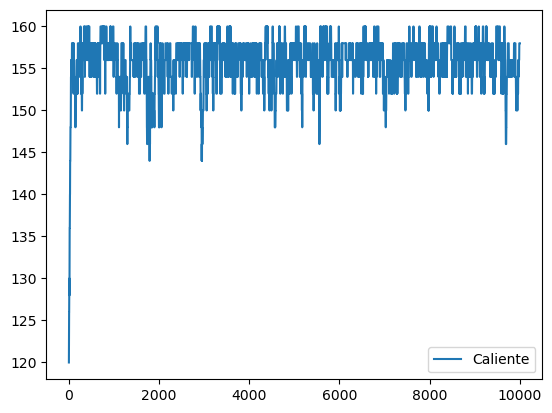

PyObject <matplotlib.legend.Legend object at 0x7fe08cef5a90>

In [18]:
#plot(enerFria1,label = "Fria")
#scatter(collect(1:10000),enerFria)
plot(enerCaliente1, label = "Caliente")
legend()

In [19]:
energiaCaliente = []
for i in 1:1000
    ΔE = Metropolis(microEstados,1/1.5,"caliente") 
    push!(energiaCaliente,ΔE)
end
return energiaCaliente

energiaFria = []
for i in 1:1000 
    ΔE = Metropolis(microEstados,1/1.5,"fria") 
    push!(energiaFria,ΔE)
end
return energiaFria

1000-element Vector{Any}:
 -0.0
  0.0
  0.0
 -0.0
 -0.0
  0.0
 -0.0
  0.0
  0.0
 -0.0
 -0.0
  0.0
 -0.0
  ⋮
 -0.0
  0.0
  0.0
  0.0
  0.0
 -0.0
 -0.0
  0.0
  0.0
  0.0
  0.0
  0.0

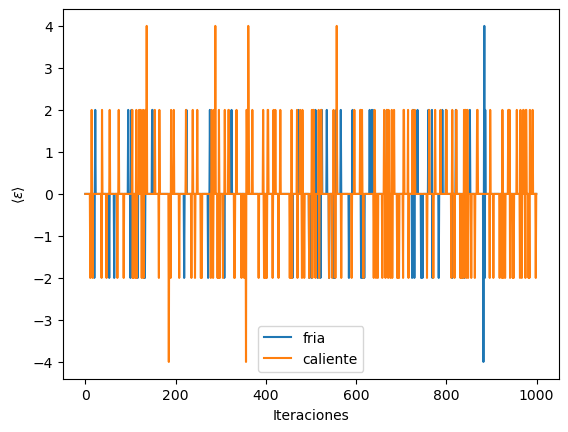

PyObject <matplotlib.legend.Legend object at 0x7fe0a110edc0>

In [20]:
plot(energiaFria,label = "fria")
plot(energiaCaliente,label = "caliente")
xlabel("Iteraciones")
ylabel(L"\langle\epsilon\rangle")
legend()